# CA5

### Imports

In [545]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingClassifier

### Reading data

In [546]:
df = pd.read_csv("./assets/train.csv")

### Data exploration and visualisation

In [547]:
print(df.shape)
df.describe()

(1000, 15)


Length (cm)  Width (cm)  Weight (g)  Pericarp Thickness (mm)  \
count   999.000000  999.000000  999.000000               998.000000   
mean     15.574675    6.641572  169.346406                 4.619499   
std       6.267303    2.139023  123.779026                 2.829503   
min       0.300000    0.100000    0.560000                 0.000000   
25%      11.290000    5.140000   79.020000                 2.400000   
50%      15.520000    6.600000  147.230000                 4.280000   
75%      19.900000    8.045000  227.625000                 6.560000   
max      35.570000   13.620000  869.970000                14.630000   

       Seed Count  Capsaicin Content  Vitamin C Content (mg)  Sugar Content  \
count  999.000000         999.000000             1000.000000     999.000000   
mean   128.731301           4.215385              142.035180       3.283534   
std     87.270366           3.163125               72.246142       1.938264   
min      0.040000           0.010000                0.950000       0.010000   
25%     55.390000           1.710000               92.290000       1.865000   
50%    119.490000           3.590000              141.730000       3.140000   
75%    186.845000           6.115000              192.720000       4.555000   
max    487.260000          19.020000              450.290000       9.360000   

       Moisture Content    Firmness  \
count       1000.000000  999.000000   
mean          90.878380    3.679179   
std           18.724314    1.034726   
min           31.400000    0.850000   
25%           78.585000    2.980000   
50%           89.690000    3.660000   
75%          103.200000    4.375000   
max          158.300000    8.250000   

       Average Daily Temperature During Growth (celcius)  \
count                                        1000.000000   
mean                                           19.641960   
std                                             6.436255   
min                                             0.840000   
25%                                            15.397500   
50%                                            19.495000   
75%                                            23.530000   
max                                            40.700000   

       Scoville Heat Units (SHU)  
count                1000.000000  
mean                70941.260020  
std                108149.917069  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                121349.617500  
max                527639.860000

In [548]:
# Checking the data types to see if i need encoding
print(df.dtypes)

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                 object
Harvest Time                                          object
Average Daily Temperature During Growth (celcius)    float64
Average Temperature During Storage (celcius)          object
Scoville Heat Units (SHU)                            float64
dtype: object


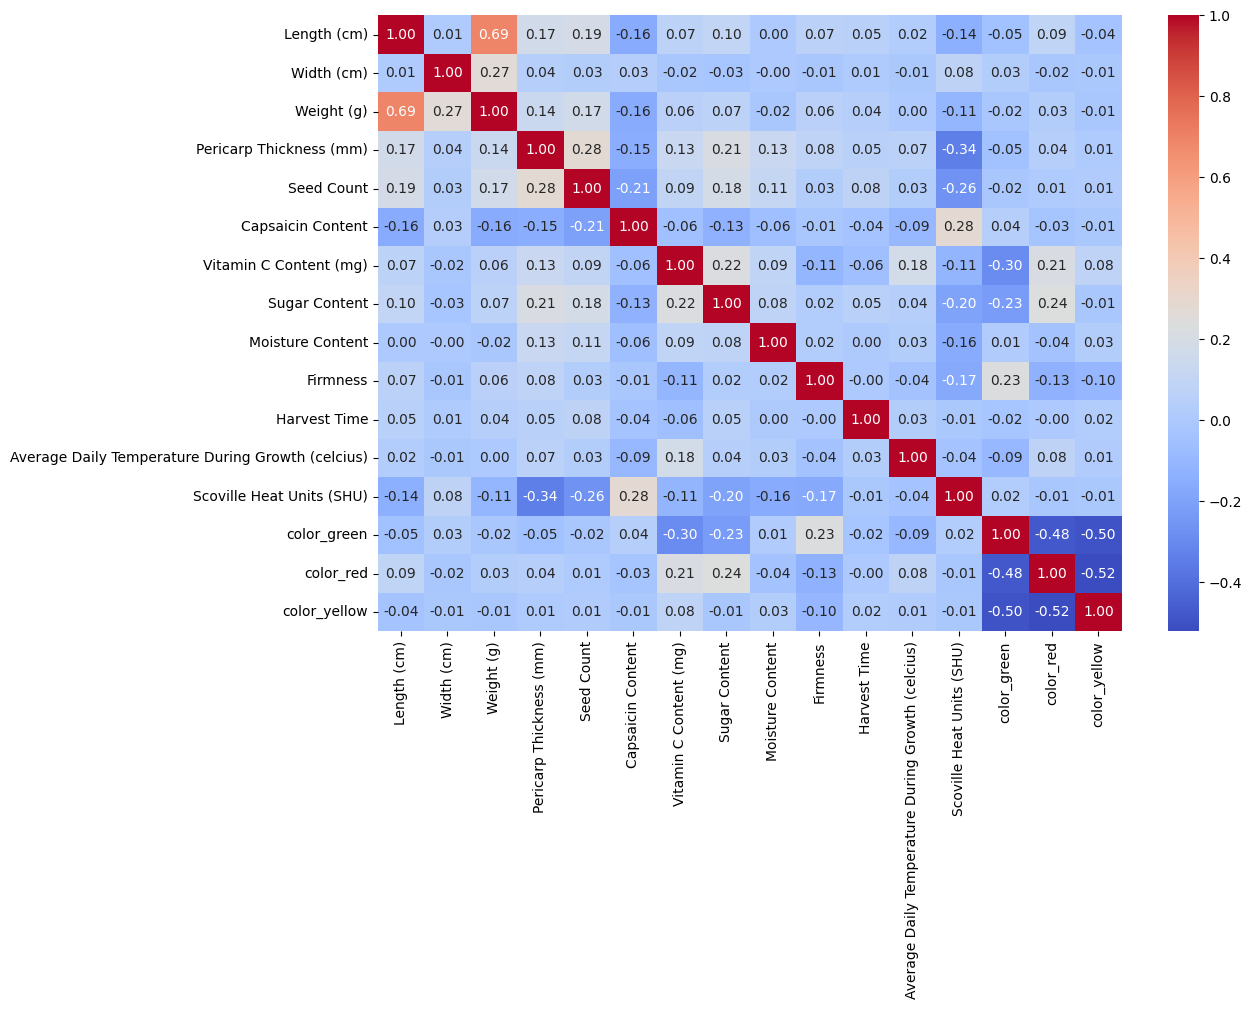

In [549]:
# Decoding dataset for visualization
df_decoded = pd.get_dummies(df, columns = ["color"], dtype = int)

mapping = {"Morning": 1, "Midday": 2, "Evening": 3}
df_decoded["Harvest Time"] = df_decoded["Harvest Time"].map(mapping)

# Too many missing values, and it does not make sense for target values
df_decoded = df_decoded.drop(columns = ["Average Temperature During Storage (celcius)"])

plt.figure(figsize = (12, 8))
sns.heatmap(df_decoded.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

In [550]:
print("Missing Values:\n", df.isnull().sum(), "\n")
print("Duplicates:", df.duplicated().sum())

Missing Values:
 Length (cm)                                            1
Width (cm)                                             1
Weight (g)                                             1
Pericarp Thickness (mm)                                2
Seed Count                                             1
Capsaicin Content                                      1
Vitamin C Content (mg)                                 0
Sugar Content                                          1
Moisture Content                                       0
Firmness                                               1
color                                                  1
Harvest Time                                           0
Average Daily Temperature During Growth (celcius)      0
Average Temperature During Storage (celcius)         648
Scoville Heat Units (SHU)                              0
dtype: int64 

Duplicates: 0


There is alot of missing values we have to deal with,  
however there is not any duplicates.  
We know too litle too make a conclusion.  
In addition, there is alot of cleaning to do before we can visualize the data.  
The visualization and conclusion will therefore be made after the data cleaning.

### Data cleaning and more visualisation

Our plan is to remove the feature "Average Temperature During Storage (celcius)".  
The feature seems too unnecessary to imputate the missing data.  
We will also remove the data from the other missing values  
since there is not many of them.

In [551]:
# Dealing with missing values: Removal
df = df.drop(columns = ["Average Temperature During Storage (celcius)"])
df = df.dropna()
print(f"Shape: {df.shape}")

Shape: (990, 14)


We still have a good amount of data to work with.

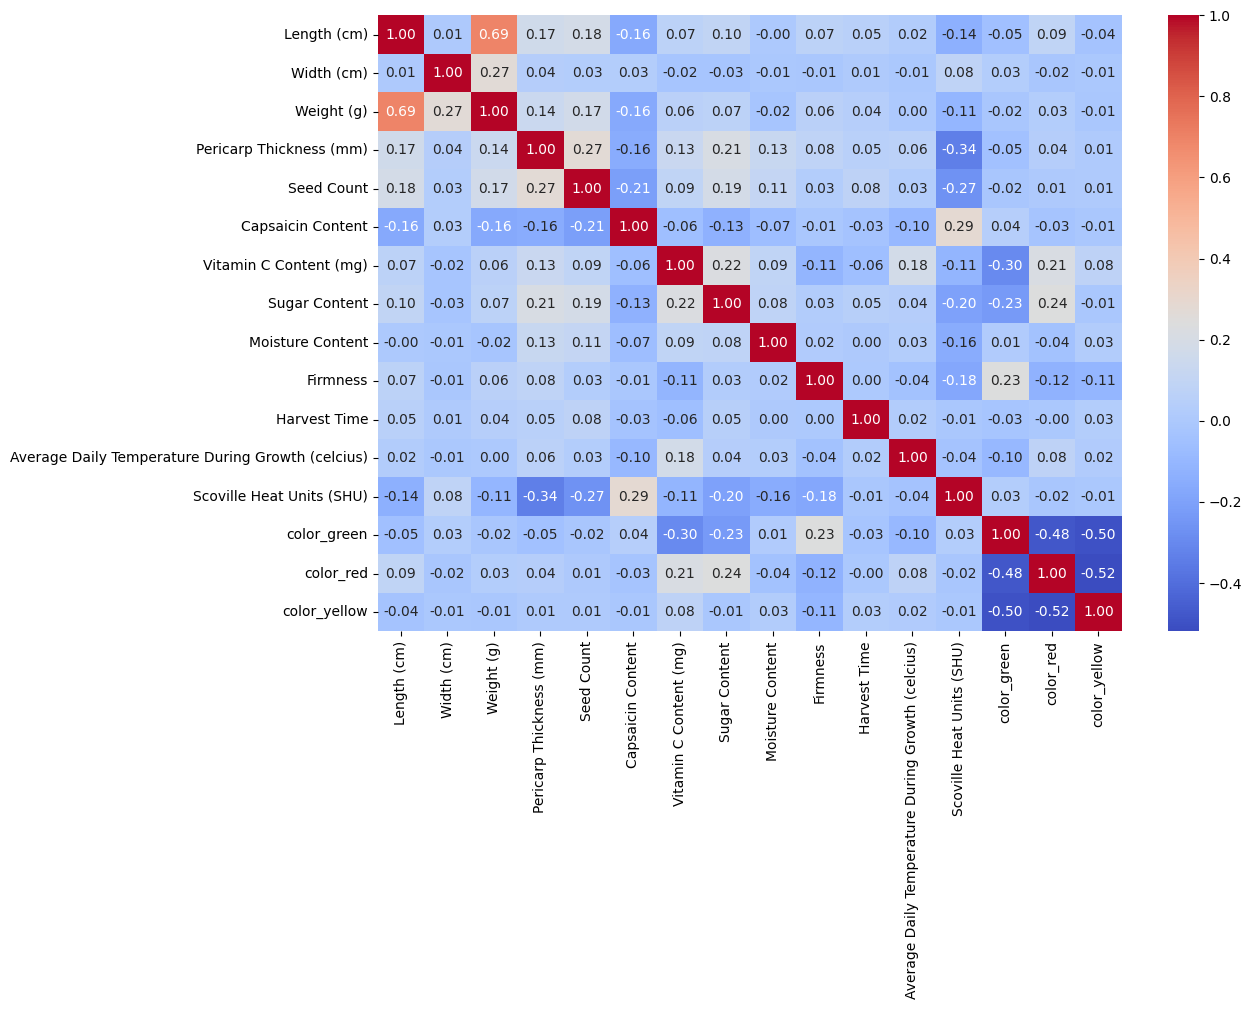

In [552]:
# Decoding again for our main dataset
df = pd.get_dummies(df, columns = ["color"], dtype = int)

mapping = {"Morning": 1, "Midday": 2, "Evening": 3}
df["Harvest Time"] = df["Harvest Time"].map(mapping)

# Revisiting the correlation heatmap
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

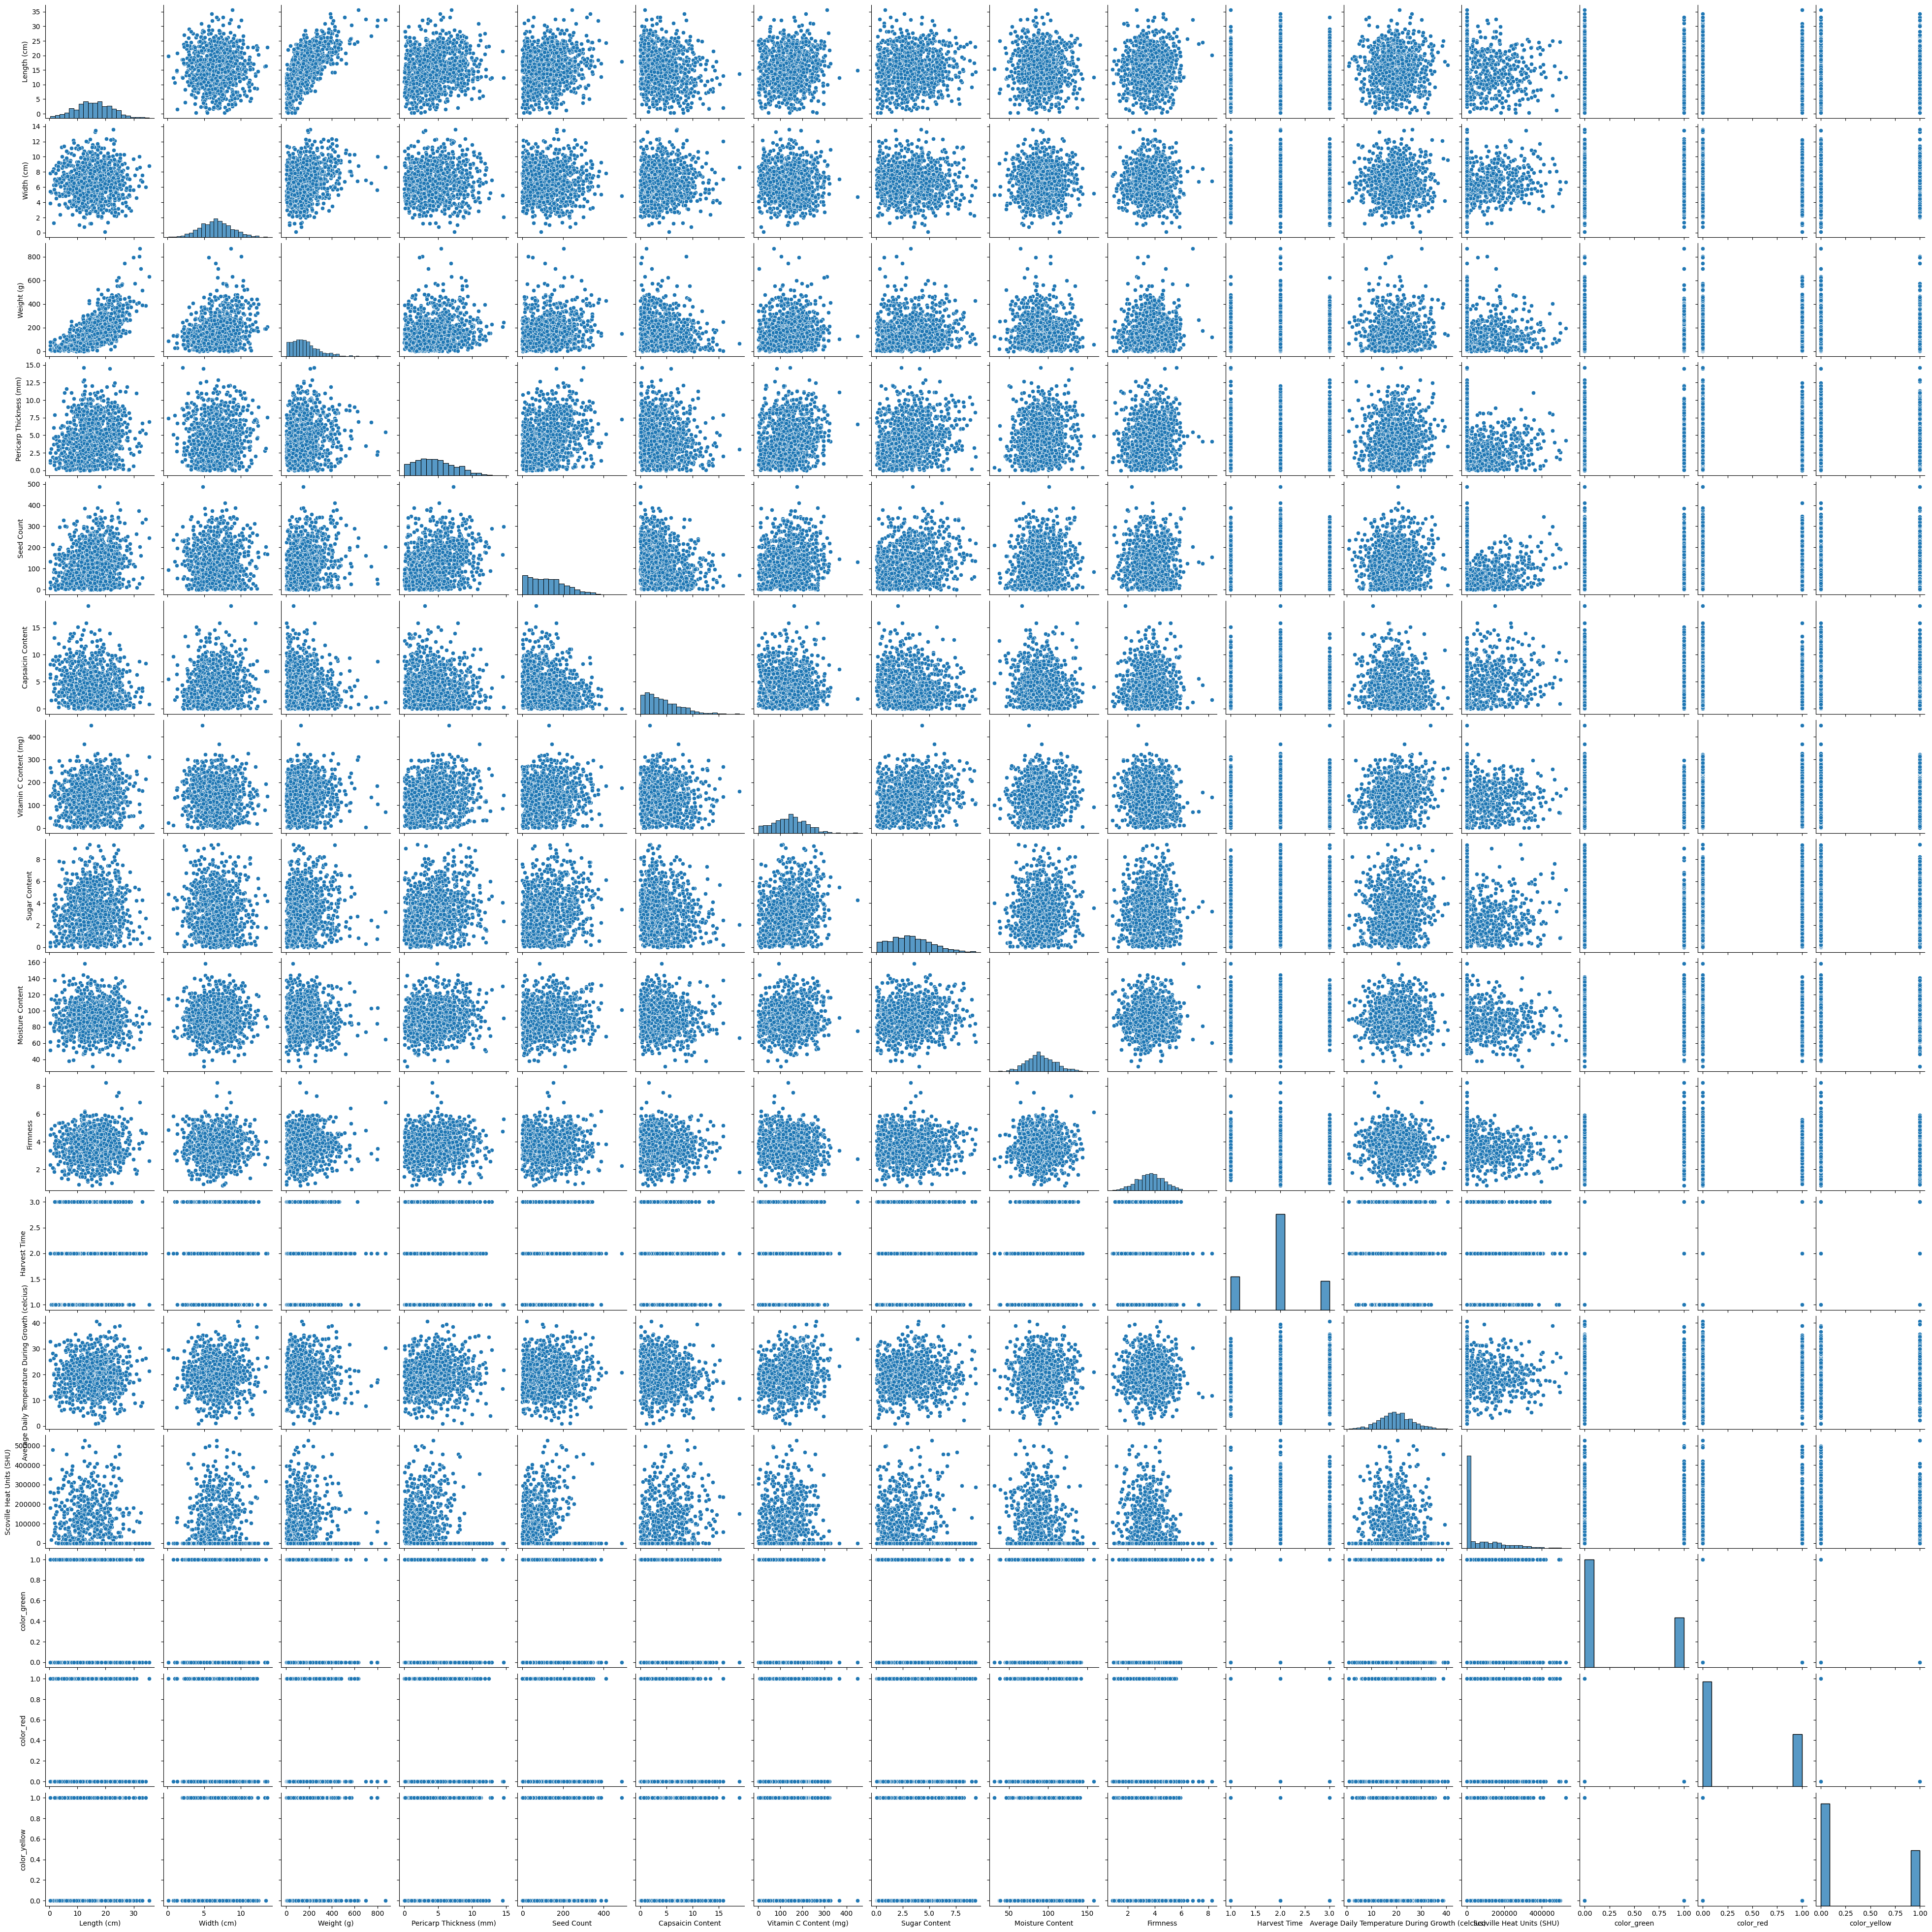

In [553]:
# Checking patterns with pairplot
sns.pairplot(df)
plt.show()

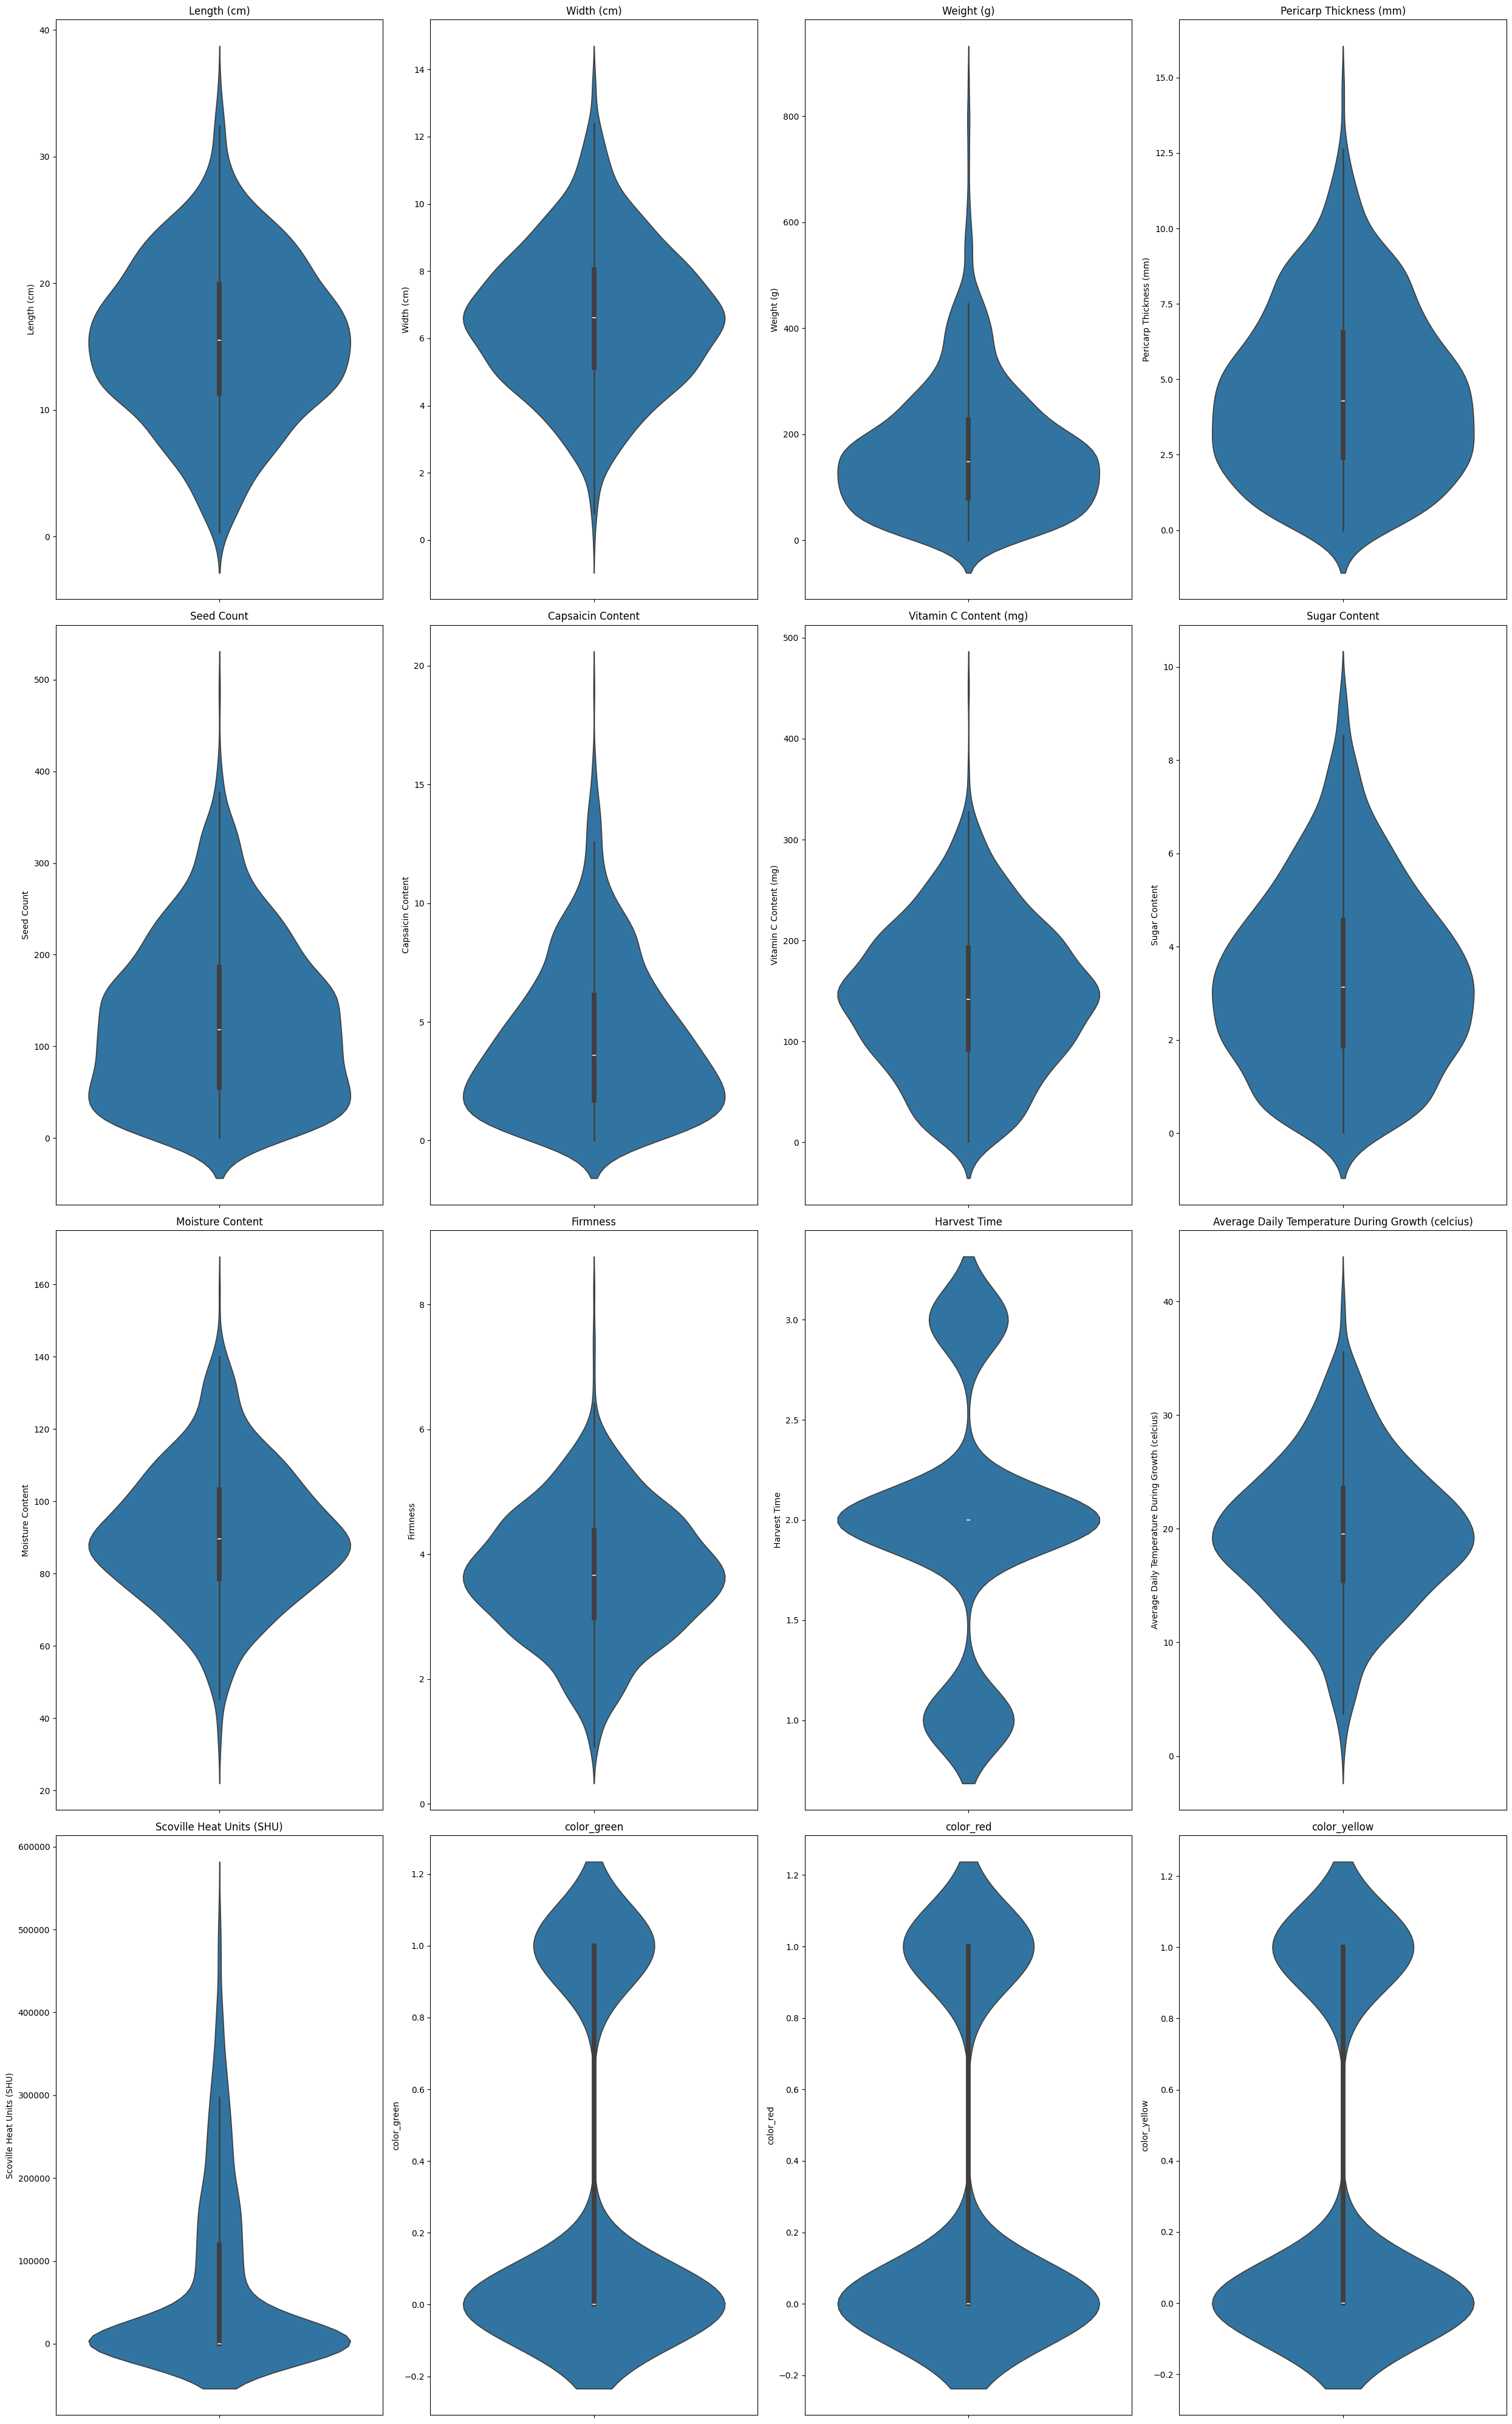

In [557]:
# Looking closer for outliers
numeric_features = df.select_dtypes(include = "number").columns

num_features = len(numeric_features)
fig, axes = plt.subplots(4, 4, figsize = (25, 40))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.violinplot(y = df[feature], ax = axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

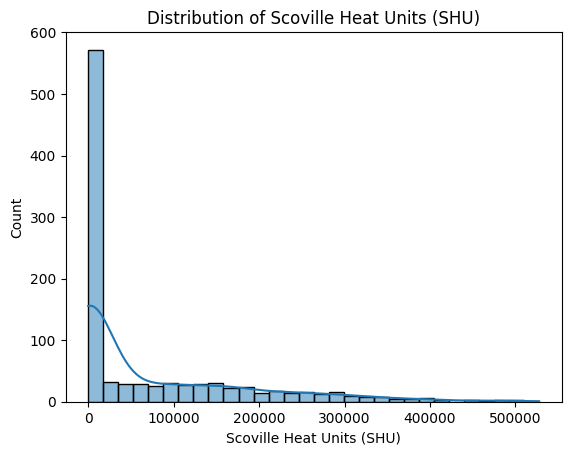

Skewness: 1.62


In [558]:
# Checking for inbalance
sns.histplot(df["Scoville Heat Units (SHU)"], kde = True, bins = 30)
plt.title("Distribution of Scoville Heat Units (SHU)")
plt.show()

# Checking for skewness
skew = df["Scoville Heat Units (SHU)"].skew()
print(f"Skewness: {skew:.2f}")

In [559]:
# We know that SHU = 0 is bellpeppers
num_zero = (df["Scoville Heat Units (SHU)"] == 0).sum()
num_over_zero = (df["Scoville Heat Units (SHU)"] > 0).sum()

print(f"Bell Peppers: {num_zero}")
print(f"Chilli Peppers: {num_over_zero}")


Bell Peppers: 537
Chilli Peppers: 453


#### Conclusion

The target value has a skewness of 1.61 and we will therefore consider the dataset inbalanced.  
We can use k-fold to cross validate the model.
On the other hand, we can use stritified k fold if we work around the data.    
We can use some form of dimension reduction that can also reduce noise to help us mitigate outliers.  
This dataset is allready small, we do not want discard more data unless it is necessary.  
We will also remove outliers by calculating the IQR before the other preprocessing.  
There is not any close correlation between the different features,  
thus we must use dimension reduction instead of selection, or we can use both.  
This task will try out regression analysis and a two step analysis.

In [560]:
# Dealing with outliers
numeric_cols = df.select_dtypes(include = "number")

# Calculate IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_filtered = df[~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis = 1)]

print(df_filtered.shape)

(509, 16)


In [561]:
droppes_1 = ["Harvest Time", "Average Daily Temperature During Growth (celcius)"]
droppes_2 = ["Moisture Content", "Firmness"]

# Splitting Data
X = df_filtered.drop(columns = ["Scoville Heat Units (SHU)"])
y = df_filtered["Scoville Heat Units (SHU)"]

### Data preprocessing

In [630]:
# Visualizing the n_components for PCA
num_components = 0.85

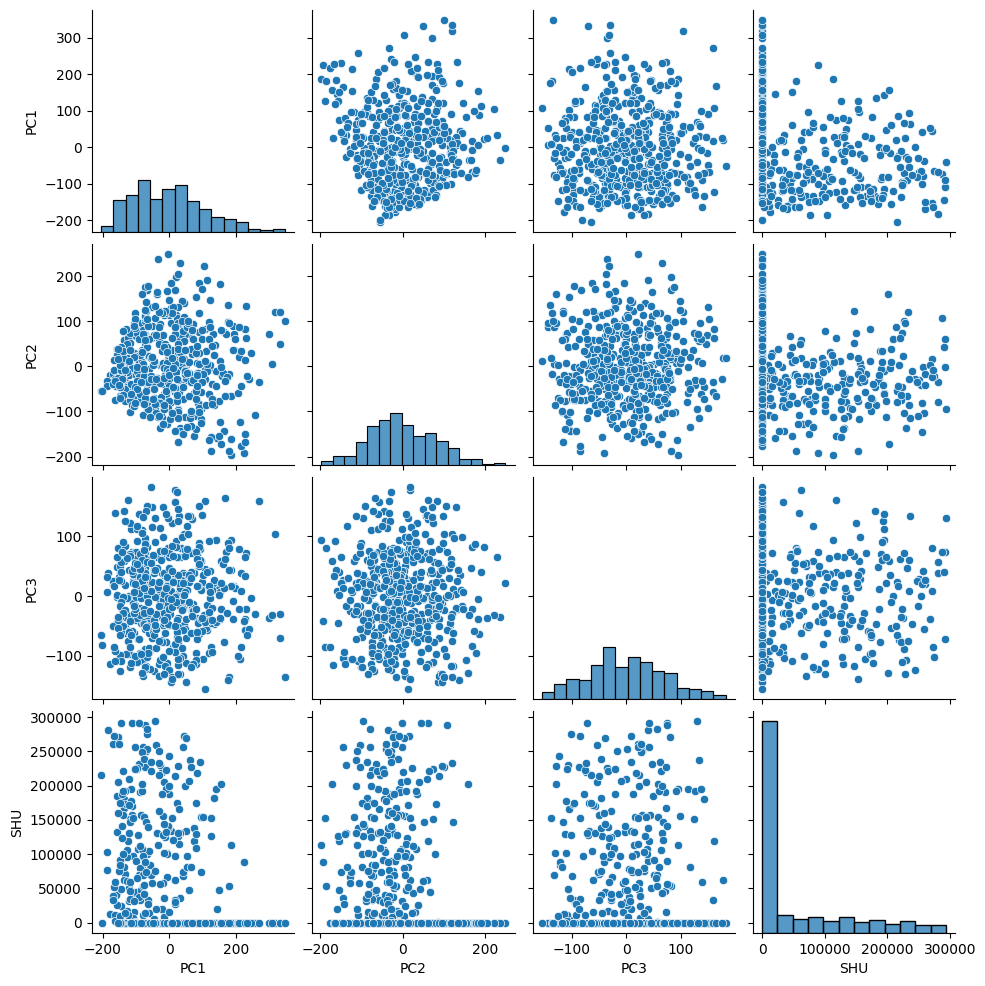

In [631]:
# Create a pairplot with pca features
pca = PCA(n_components = num_components)
X_pca = pca.fit_transform(X)

columns = [f"PC{i + 1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=columns)
df_pca = df_pca.reset_index(drop=True)
y_clean = y.reset_index(drop=True)
df_pca["SHU"] = y_clean

sns.pairplot(df_pca)
plt.show()


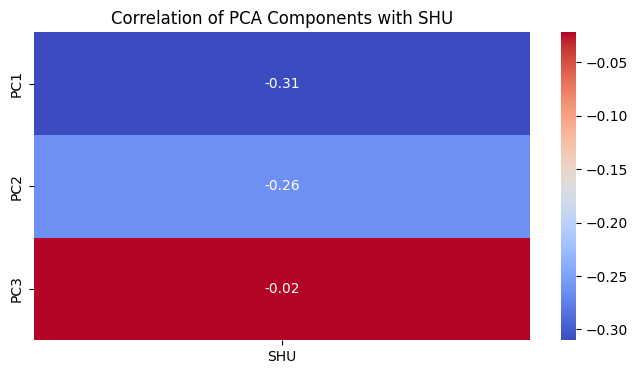

In [632]:
# Heatmap of PCA components vs SHU
pc_corr = df_pca.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(pc_corr[["SHU"]].drop("SHU"), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation of PCA Components with SHU")
plt.show()

In [633]:
# Prepering for pipeline C
y_is_spicy = (y > 0).astype(int)
X_spicy = X[y_is_spicy == 1]
y_spicy = y[y_is_spicy == 1]

In [634]:
# A
pipeA = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ("scalar", StandardScaler()),
    ("pca", PCA(n_components = num_components)),
    ("regressor", Ridge())
])


# C
pipeC_clf = Pipeline([
    ("scalar", StandardScaler()),
    ("pca", PCA(n_components = num_components)),
    ("classifier", HistGradientBoostingClassifier(random_state = 42))
])

pipeC_reg = Pipeline([
    ("scalar", StandardScaler()),
    ("pca", PCA(n_components = num_components)),
    ("regressor", Ridge())
])

### Modelling

In [ ]:
# Pipeline A
param_grid_A = {
    "regressor__alpha": np.arange(0, 20, 2)
}

gs_A = GridSearchCV(estimator = pipeA, 
                    param_grid = param_grid_A, 
                    scoring = "neg_mean_absolute_error", 
                    cv = KFold(n_splits = 10, shuffle = True, random_state = 42), 
                    n_jobs = -1)
    
gs_A.fit(X, y)

print("Best params:", gs_A.best_params_)
print("Best MAE:", gs_A.best_score_)

Best params: {'regressor__alpha': 18}
Best MAE: -52257.25906284357


In [640]:
# Pipeline C, clf
param_grid_C_clf = {
    "classifier__learning_rate": [0.005, 0.015, 0.002],
    "classifier__max_iter": [300, 400, 500]
}

gs_C_clf = GridSearchCV(estimator = pipeC_clf, 
                  param_grid = param_grid_C_clf,
                  cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), 
                  scoring = "accuracy",
                  n_jobs = -1)
    
gs_C_clf.fit(X, y_is_spicy)

print("params:", gs_C_clf.best_params_)
print("accuracy:", gs_C_clf.best_score_)

params: {'classifier__learning_rate': 0.015, 'classifier__max_iter': 500}
accuracy: 0.8802352941176471


In [637]:
# Pipeline C, reg
param_grid_C_reg = {
    "regressor__alpha": [0, 0.001, 0.1, 1]
}
gs_C_reg = GridSearchCV(estimator = pipeC_reg, 
                    param_grid = param_grid_C_reg, 
                    scoring = "neg_mean_absolute_error", 
                    cv = KFold(n_splits = 10, shuffle = True, random_state = 42), 
                    n_jobs = -1)
    
gs_C_reg.fit(X_spicy, y_spicy)

print("Best params:", gs_C_reg.best_params_)
print("Best MAE:", gs_C_reg.best_score_)

Best params: {'regressor__alpha': 0}
Best MAE: -63249.25151733998


### Final evaluation

In [638]:
model = gs_A.best_estimator_

cv_scores = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_absolute_error")
print("Mean MAE:", -cv_scores.mean())

Mean MAE: 52387.99347132634


### Kaggle submission

In [639]:
df_test = pd.read_csv("./assets/test.csv")

# Decoding
df_test = pd.get_dummies(df_test, columns = ["color"], dtype = int)

mapping = {"Morning": 1, "Midday": 2, "Evening": 3}
df_test["Harvest Time"] = df_test["Harvest Time"].map(mapping)

df_test = df_test.drop(columns = ["Average Temperature During Storage (celcius)"])

submission = model.predict(df_test)
submission = pd.DataFrame(submission, columns = ["Scoville Heat Units (SHU)"])
submission.index = df_test.index
submission.index.name = "index"

submission.to_csv("submission.csv", index = True)